# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

## Описание проекта

Заказчик этого исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.
Бизнес-метрика и другие данные

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:

- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

### Описание данных

В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:

- `id` — номер записи;
- `adults` — количество взрослых постояльцев;
- `arrival_date_year` — год заезда;
- `arrival_date_month` — месяц заезда;
- `arrival_date_week_number` — неделя заезда;
- `arrival_date_day_of_month` — день заезда;
- `babies` — количество младенцев;
- `booking_changes` — количество изменений параметров заказа;
- `children` — количество детей от 3 до 14 лет;
- `country` — гражданство постояльца;
- `customer_type` — тип заказчика:
    - `Contract` — договор с юридическим лицом;
    - `Group` — групповой заезд;
    - `Transient` — не связано с договором или групповым заездом;
    - `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа `Transient`.
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
- `distribution_channel` — канал дистрибуции заказа;
- `is_canceled` — отмена заказа;
- `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
- `lead_time` — количество дней между датой бронирования и датой прибытия;
- `meal` — опции заказа:
   - `SC` — нет дополнительных опций;
   - `BB` — включён завтрак;
   - `HB` — включён завтрак и обед;
   - `FB` — включён завтрак, обед и ужин.
- `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
- `previous_cancellations` — количество отменённых заказов у клиента;
- `required_car_parking_spaces` — необходимость места для автомобиля;
- `reserved_room_type` — тип забронированной комнаты;
- `stays_in_weekend_nights` — количество ночей в выходные дни;
- `stays_in_week_nights` — количество ночей в будние дни;
- `total_nights` — общее количество ночей;
- `total_of_special_requests` — количество специальных отметок.

##  Открытие файлов с данными

### Импорт необходимых библиотек для работы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

import warnings

warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

BUDGET = 400_000
RANDOM = 12345  # значение random_state для моделирования

### Загрузка данных из файлов `hotel_train.csv`,  и `hotel_test.csv` в датафреймы `hotel_train`, и `hotel_test` соответственно.

In [2]:
try:
    hotel_train = pd.read_csv("/datasets/hotel_train.csv")
    hotel_test = pd.read_csv("/datasets/hotel_test.csv")
except FileNotFoundError:
    hotel_train = pd.read_csv(
        "https://code.s3.yandex.net/datasets/hotel_train.csv")
    hotel_test = pd.read_csv(
        "https://code.s3.yandex.net/datasets/hotel_test.csv")

### Вывод на экран первых пяти строк данных методом `head()`

In [3]:
hotel_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [4]:
hotel_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


**Данные загружены**

## Предобработка и исследовательский анализ данных

### Общая информация по датасетам

In [5]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [6]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Cтолбцы таблиц не содержат пропусков.

### Поиск дубликатов

#### Явные дубликаты

In [7]:
print('Количество дубликатов в обучающей выборке hotel_train',
      hotel_train.duplicated().sum())
print('Количество дубликатов в тестовой выборке hotel_test',
      hotel_test.duplicated().sum())

Количество дубликатов в обучающей выборке hotel_train 0
Количество дубликатов в тестовой выборке hotel_test 0


Явные дубликаты отсутствуют

#### Неявные дубликаты

Проверку на неявные дубликаты буду проводить в стобцах, содержащих категориальные переменные.

Категориальные переменные представлены в столбцах:

1. `customer_type` — тип заказчика. Значения: `Contract`, `Group`, `Transient`, `Transient-party`.
2.  `meal` — опции заказа. Значения: `SC`, `BB`, `HB`, `FB`.
3. `reserved_room_type` — тип забронированной комнаты. Значения: `A`, `B`, `C`, `D`, `E` , `F`, `G`.  
4. `arrival_date_month` - месяц заезда. Значения: `January`, `February`, `March`, `April`, `May`, `June`, `July`, `August`, `September`, `October`, `November`, `December`.
5. `country` - гражданство постояльца. Значения: сокращенные названия стран.
6. `distribution_channel` - канал дистрибуции заказа. Значения: `Direct`, `TA/TO`, `Corporate`, `GDS`.

In [8]:
columns = [
    'customer_type', 'meal', 'reserved_room_type', 'arrival_date_month',
    'country', 'distribution_channel'
]
datas = [hotel_train, hotel_test]

hotel_train.name = 'Тренировочный датафрейм hotel_train'
hotel_test.name = 'Тестовый датафрейм hotel_test'

for table in datas:
    print(f"Датафрейм: {table.name}\n")
    for col in columns:
        print(
            f"Столбец: {col}, уникальные значения столбца: {table[col].unique()} \n"
        )

Датафрейм: Тренировочный датафрейм hotel_train

Столбец: customer_type, уникальные значения столбца: ['Transient' 'Contract' 'Transient-Party' 'Group'] 

Столбец: meal, уникальные значения столбца: ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC'] 

Столбец: reserved_room_type, уникальные значения столбца: ['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               '] 

Столбец: arrival_date_month, уникальные значения столбца: ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June'] 

Столбец: country, уникальные значения столбца: ['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 

Есть пробелы в значениях столбца `meal`, из-за них дублируется опция SC и есть пробелы в значениях столбца `reserved_room_type`. Устраним эти недостатки методом `strip()`

In [9]:
hotel_train[['meal', 'reserved_room_type'
             ]] = hotel_train[['meal', 'reserved_room_type'
                               ]].apply(lambda x: x.str.strip())
hotel_test[['meal', 'reserved_room_type'
            ]] = hotel_test[['meal', 'reserved_room_type'
                             ]].apply(lambda x: x.str.strip())

**Неявные дубликаты и опечатки устранены**

### Оптимизация типов данных

В датасетах есть столбцы в формате `float64` и `int64`. 

Все значения имеют целочисленные значения. Приведу к оптимальному из типов `int` в зависимости от разброса значений.

Столбцы с числовыми значениями

- `id` - не трогаем 
- `is_canceled` - все 2 значения: 0 или 1. Приведем к типу `uint8`,  
- `lead_time` - разброс от 0 до 374. Подойдет тип `uint16`,
- `arrival_date_year` - до 2016 года. Подойдет тип `uint16`,  
- `arrival_date_week_number` - разброс от 0 до 53. Подойдет тип `uint8`,  
- `arrival_date_day_of_month` - разброс от 0 до 31. Подойдет тип `uint8`,  
- `stays_in_weekend_nights`- разброс от 0 до 4. Подойдет тип `uint8`,  
- `stays_in_week_nights`- разброс от 0 до 6. Подойдет тип `uint8`,  
- `adults`- разброс от 0 до 4. Подойдет тип `uint8`,
- `children`- разброс от 0 до 3. Подойдет тип `uint8`,
- `babies`- разброс от 0 до 10. Подойдет тип `uint8`,
- `is_repeated_guest`- разброс от 0 до 1. Подойдет тип `uint8`, 
- `previous_cancellations` - разброс от 0 до 26. Подойдет тип `uint8`,  
- `previous_bookings_not_canceled` - разброс от 0 до 58. Подойдет тип `uint8`,  
- `booking_changes` - разброс от 0 до 17. Подойдет тип `uint8`,   
- `days_in_waiting_list` - разброс от 0 до 259. Подойдет тип `uint16`, 
- `required_car_parking_spaces` - разброс от 0 до 3. Подойдет тип `uint8`,  
- `total_of_special_requests` - разброс от 0 до 5. Подойдет тип `uint8`,  
- `total_nights` - разброс от 0 до 10. Подойдет тип `uint8`.

In [10]:
# Список со столбцами для типа uint8
type_uint_8 = [
    'is_canceled', 'arrival_date_week_number', 'arrival_date_day_of_month',
    'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
    'babies', 'is_repeated_guest', 'previous_cancellations',
    'previous_bookings_not_canceled', 'booking_changes',
    'required_car_parking_spaces', 'total_of_special_requests', 'total_nights'
]

# Список со столбцами для типа uint16
type_uint_16 = ['lead_time', 'arrival_date_year', 'days_in_waiting_list']

# процедура для изменения типов


def change_type(data, cols, int_type):
    data[cols] = data[cols].astype(int_type)
    return print(f"Типы данных в {data.name} изменены на тип: {int_type} \n")

In [11]:
change_type(hotel_train, type_uint_8, 'uint8')
change_type(hotel_train, type_uint_16, 'uint16')
change_type(hotel_test, type_uint_8, 'uint8')
change_type(hotel_test, type_uint_16, 'uint16')

Типы данных в Тренировочный датафрейм hotel_train изменены на тип: uint8 

Типы данных в Тренировочный датафрейм hotel_train изменены на тип: uint16 

Типы данных в Тестовый датафрейм hotel_test изменены на тип: uint8 

Типы данных в Тестовый датафрейм hotel_test изменены на тип: uint16 



In [12]:
hotel_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              65229 non-null  int64 
 1   is_canceled                     65229 non-null  uint8 
 2   lead_time                       65229 non-null  uint16
 3   arrival_date_year               65229 non-null  uint16
 4   arrival_date_month              65229 non-null  object
 5   arrival_date_week_number        65229 non-null  uint8 
 6   arrival_date_day_of_month       65229 non-null  uint8 
 7   stays_in_weekend_nights         65229 non-null  uint8 
 8   stays_in_week_nights            65229 non-null  uint8 
 9   adults                          65229 non-null  uint8 
 10  children                        65229 non-null  uint8 
 11  babies                          65229 non-null  uint8 
 12  meal                            65229 non-null

In [13]:
hotel_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              32412 non-null  int64 
 1   is_canceled                     32412 non-null  uint8 
 2   lead_time                       32412 non-null  uint16
 3   arrival_date_year               32412 non-null  uint16
 4   arrival_date_month              32412 non-null  object
 5   arrival_date_week_number        32412 non-null  uint8 
 6   arrival_date_day_of_month       32412 non-null  uint8 
 7   stays_in_weekend_nights         32412 non-null  uint8 
 8   stays_in_week_nights            32412 non-null  uint8 
 9   adults                          32412 non-null  uint8 
 10  children                        32412 non-null  uint8 
 11  babies                          32412 non-null  uint8 
 12  meal                            32412 non-null

**Типы данных изменены, память оптимизирована**

### Поиск выбросов и аномальных значений 

Проверим сводные статистики по выборкам.

In [14]:
hotel_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,65229.0,43544.069172,25614.858971,0.0,19108.0,40554.0,67414.0,84121.0
is_canceled,65229.0,0.368609,0.482431,0.0,0.0,0.0,1.0,1.0
lead_time,65229.0,96.337917,96.127545,0.0,17.0,64.0,151.0,374.0
arrival_date_year,65229.0,2015.719021,0.449481,2015.0,2015.0,2016.0,2016.0,2016.0
arrival_date_week_number,65229.0,31.339772,13.464024,1.0,21.0,34.0,42.0,53.0
arrival_date_day_of_month,65229.0,15.847813,8.748182,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,65229.0,0.825185,0.853477,0.0,0.0,1.0,2.0,4.0
stays_in_week_nights,65229.0,2.224793,1.354992,0.0,1.0,2.0,3.0,6.0
adults,65229.0,1.836576,0.480245,0.0,2.0,2.0,2.0,4.0
children,65229.0,0.074890,0.334243,0.0,0.0,0.0,0.0,3.0


In [15]:
hotel_test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,32412.0,60131.505183,29953.586177,6086.0,45291.75,53394.5,89800.25,97903.0
is_canceled,32412.0,0.388467,0.487409,0.0,0.00,0.0,1.00,1.0
lead_time,32412.0,97.587869,86.507146,0.0,23.00,76.0,155.00,373.0
arrival_date_year,32412.0,2017.000000,0.000000,2017.0,2017.00,2017.0,2017.00,2017.0
arrival_date_week_number,32412.0,17.804054,9.177384,1.0,10.00,18.0,25.00,35.0
arrival_date_day_of_month,32412.0,15.656948,8.766429,1.0,8.00,15.5,23.00,31.0
stays_in_weekend_nights,32412.0,0.867888,0.853394,0.0,0.00,1.0,2.00,4.0
stays_in_week_nights,32412.0,2.340090,1.375170,0.0,1.00,2.0,3.00,6.0
adults,32412.0,1.858602,0.489341,0.0,2.00,2.0,2.00,4.0
children,32412.0,0.083765,0.343470,0.0,0.00,0.0,0.00,3.0


In [16]:
# создание функция для дальнейшего вывода гистограмм.


def drow_barplot_values(data_with_column):
    ax = sns.barplot(x=data_with_column.unique(),
                     y=data_with_column.value_counts())
    # для параметра bar_label необходим matplotlib версии не ниже 3.4
    # в тренажере практикума к сожалению версия ниже.
    # значения столбцов не выводятся...
    plt.bar_label(ax.containers[0])
    plt.show()


def drow_boxplot(column):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.title('Тренировочная выборка')
    sns.boxplot(y=column, color='g', fliersize=6, data=hotel_train)
    plt.subplot(122)
    plt.title('Тестовая выборка')
    sns.boxplot(y=column, color='r', fliersize=6, data=hotel_test)
    plt.show()


def drow_barplot_percent(dataset, column_x, column_y, size):
    plt.figure(figsize=size)
    plt.title("Отмененные бронирования", fontsize=20, pad=10)
    ax = sns.barplot(data=dataset, x=column_x, y=column_y, ci=None)
    plt.xlabel("Доля отмененных бронирований", fontsize=12, labelpad=5)
    # для параметра bar_label необходим matplotlib версии не ниже 3.4
    # в тренажере практикума к сожалению версия ниже.
    # значения столбцов не выводятся...
    plt.bar_label(ax.containers[0])
    plt.show()

В столбце `babies` в трейне есть два аномальных значения 9 и 10

In [17]:
print(hotel_train['babies'].sort_values().unique())
print()
print(hotel_train['babies'].value_counts())

[ 0  1  2  9 10]

0     64777
1       447
2         3
10        1
9         1
Name: babies, dtype: int64


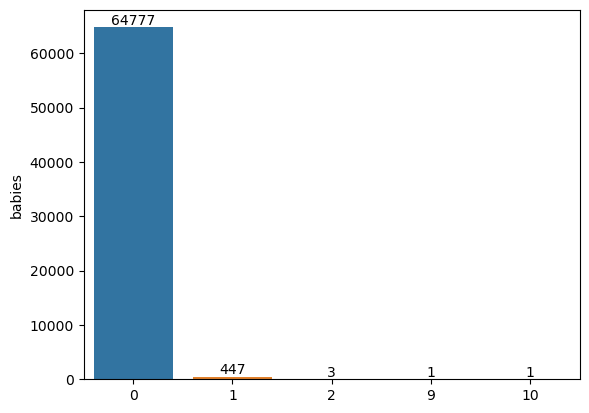

In [18]:
drow_barplot_values(hotel_train['babies'])

Скорее всего это ошибка ввода. Т.к. с нулем младенцев у нас самое большое количество строк и медиана, как и среднее равны нулю, можно заменить эти два значения на 0.

In [19]:
hotel_train.loc[hotel_train['babies'] > 8, 'babies'] = 0

In [20]:
hotel_train['has_babies'] = hotel_train['babies'].apply(
    lambda x: 1 if x > 0 else 0).astype('uint8')
hotel_test['has_babies'] = hotel_test['babies'].apply(
    lambda x: 1 if x > 0 else 0).astype('uint8')

В столбце `lead_time` - количество дней между датой бронирования и датой прибытия, есть выбросы в обеих выборках. Ниже можно увидеть на графиках

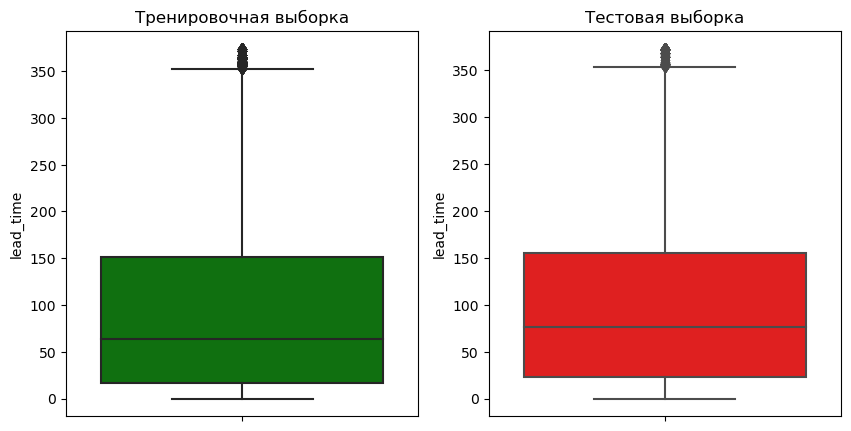

In [21]:
drow_boxplot('lead_time')

In [22]:
print(
    f"Количество записей в столбце `lead_time` в тренировочной выборке:{len(hotel_train[hotel_train['lead_time'] >350])},\n\
      что составляет: {(len(hotel_train[hotel_train['lead_time'] >350]) / len(hotel_train['lead_time'])) * 100}% от общего числа записей"
)
print(
    f"Количество записей в столбце `lead_time` в тестовой выборке:{len(hotel_test[hotel_train['lead_time'] >350])},\n\
      что составляет: {(len(hotel_test[hotel_test['lead_time'] >350]) / len(hotel_test['lead_time'])) * 100}% от общего числа записей"
)

Количество записей в столбце `lead_time` в тренировочной выборке:567,
      что составляет: 0.8692452743411673% от общего числа записей
Количество записей в столбце `lead_time` в тестовой выборке:209,
      что составляет: 0.5769468098235222% от общего числа записей


В обеих выборках есть выбросы за 350 дней, возможно это просто не снятые и не актуальные брони. Количество таких записей меньше 1% в обеих выборках. Строки можно удалить, на дальнейшее исследование это не повлияет.

In [23]:
hotel_train = hotel_train.loc[hotel_train['lead_time'] < 350]
hotel_test = hotel_test.loc[hotel_test['lead_time'] < 350]

Еще один столбец с большим максимумом и нулевой медианой - `days_in_waiting_list` 

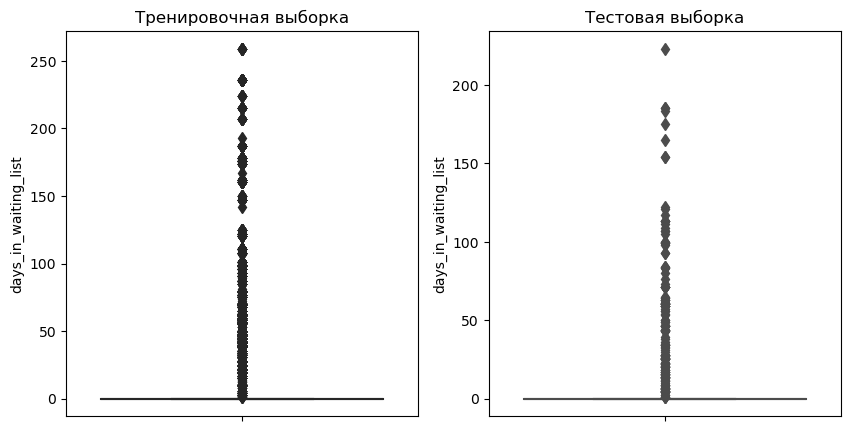

In [24]:
drow_boxplot('days_in_waiting_list')

In [25]:
print(hotel_train['days_in_waiting_list'].sort_values().unique())
print()
print(hotel_train['days_in_waiting_list'].value_counts())

[  0   1   2   3   4   5   6   8   9  10  11  12  13  14  15  17  19  20
  21  22  24  25  27  28  30  31  32  33  34  35  38  39  40  41  42  43
  44  45  46  47  48  49  50  53  55  56  57  58  59  60  61  62  63  65
  68  69  70  71  72  74  75  76  77  79  80  81  85  87  89  91  93  96
  98  99 101 107 108 111 120 122 125 142 147 150 160 162 167 174 176 178
 187 193 207 215 224 236 259]

0      61373
39       185
58       164
44       137
31       126
       ...  
14         1
76         1
81         1
74         1
167        1
Name: days_in_waiting_list, Length: 97, dtype: int64


Данный столбец содержит информацию сколько дней заказ ожидал подтверждения. Большинство заказов подтверждались в тот же день.
Далее разброс идет до 259 дней. Проверим количество отмен и подтверждений при условии больше 1 дня (как среднее значение) на подтверждение.

In [26]:
print('Тренировочная выборка:')
print(
    'Количество подтвержденных заказов при ожидании подверждения брони:',
    len(hotel_train.loc[(hotel_train['days_in_waiting_list'] > 1)
                        & (hotel_train['is_canceled'] == 0)]))
print(
    'Количество отмененных заказов при ожидании подверждения брони:',
    len(hotel_train.loc[(hotel_train['days_in_waiting_list'] > 1)
                        & (hotel_train['is_canceled'] == 1)]), '\n')
print('Тестовая выборка:')
print(
    'Количество подтвержденных заказов при ожидании подверждения брони:',
    len(hotel_test.loc[(hotel_test['days_in_waiting_list'] > 1)
                       & (hotel_test['is_canceled'] == 0)]))
print(
    'Количество отмененных заказов при ожидании подверждения брони:',
    len(hotel_test.loc[(hotel_test['days_in_waiting_list'] > 1)
                       & (hotel_test['is_canceled'] == 1)]))

Тренировочная выборка:
Количество подтвержденных заказов при ожидании подверждения брони: 1102
Количество отмененных заказов при ожидании подверждения брони: 2111 

Тестовая выборка:
Количество подтвержденных заказов при ожидании подверждения брони: 69
Количество отмененных заказов при ожидании подверждения брони: 105


Соотношение отменненых и неотменных броней 2 к 1. Значи все-таки это особенность отеля, что потдвердение брони может длиться достаточно долгий срок. Оставляю как есть.

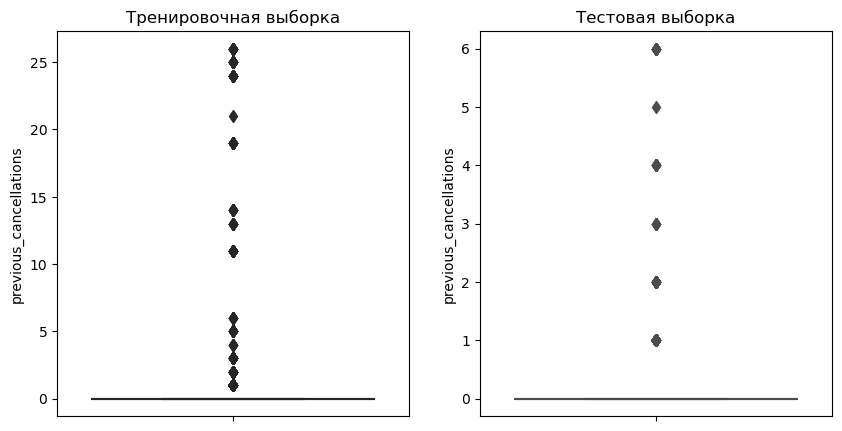

In [27]:
drow_boxplot('previous_cancellations')

In [28]:
print(hotel_train['previous_cancellations'].sort_values().unique())
print()
print(hotel_train['previous_cancellations'].value_counts())

[ 0  1  2  3  4  5  6 11 13 14 19 21 24 25 26]

0     59298
1      5021
2        53
3        51
11       35
24       28
25       19
26       18
19       17
5        13
13       12
14       11
6         7
4         5
21        1
Name: previous_cancellations, dtype: int64


In [29]:
print('Тренировочная выборка:')
print(
    'Количество подтвержденных заказов у клиентов, ранее отменявших бронь:',
    len(hotel_train.loc[(hotel_train['previous_cancellations'] > 5)
                        & (hotel_train['is_canceled'] == 0)]))
print(
    'Количество отмененных заказов у клиентов, ранее отменявших бронь:',
    len(hotel_train.loc[(hotel_train['previous_cancellations'] > 5)
                        & (hotel_train['is_canceled'] == 1)]), '\n')
print('Тестовая выборка:')
print(
    'Количество подтвержденных заказов у клиентов, ранее отменявших бронь:',
    len(hotel_test.loc[(hotel_test['previous_cancellations'] > 5)
                       & (hotel_test['is_canceled'] == 0)]))
print(
    'Количество отмененных заказов у клиентов, ранее отменявших бронь:',
    len(hotel_test.loc[(hotel_test['previous_cancellations'] > 5)
                       & (hotel_test['is_canceled'] == 1)]))

Тренировочная выборка:
Количество подтвержденных заказов у клиентов, ранее отменявших бронь: 26
Количество отмененных заказов у клиентов, ранее отменявших бронь: 122 

Тестовая выборка:
Количество подтвержденных заказов у клиентов, ранее отменявших бронь: 15
Количество отмененных заказов у клиентов, ранее отменявших бронь: 0


Самый недобросовестный клиент с 26-ю ранее отменнеными заказами

In [30]:
display(hotel_train.loc[hotel_train['previous_cancellations'] == 26])

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,has_babies
6273,8602,1,275,2015,October,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2,0
6274,8603,1,275,2015,October,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2,0
6275,8604,1,275,2015,October,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2,0
6276,8605,1,275,2015,October,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2,0
6277,8606,1,275,2015,October,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2,0
6278,8607,1,275,2015,October,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2,0
6279,8608,1,275,2015,October,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2,0
6280,8609,1,275,2015,October,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2,0
6281,8610,1,275,2015,October,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2,0
6282,8611,1,275,2015,October,41,4,2,0,2,0,0,HB,PRT,TA/TO,0,26,0,A,0,0,Transient,0,0,2,0


На выходе абсолютно одинаковые строки с разным столбцом `id` - номер записи. Варианты разные от сбоя в брони, до того, что клиент бронировал много номеров на себя, но для разных людей. Т.к. уточнить это не представляется возможным - оставляем без изменений. Большие значения оставляем - для таких клиентов и планируется депозит.

Столбец `previous_bookings_not_canceled` - количество подтверждённых заказов у клиента

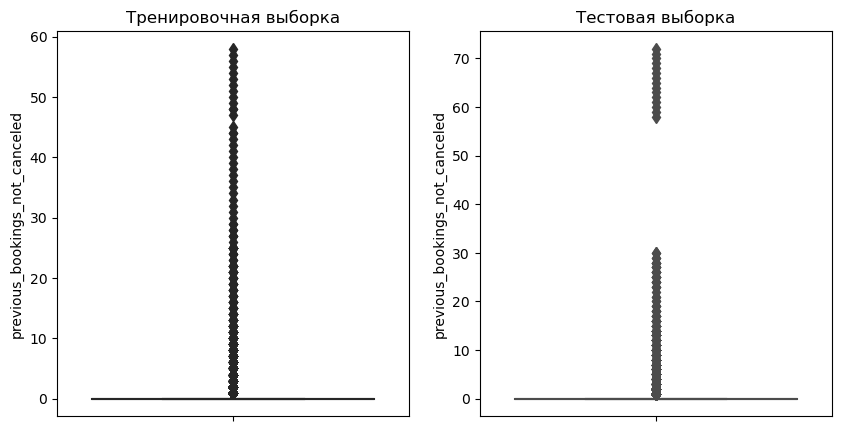

In [31]:
drow_boxplot('previous_bookings_not_canceled')

In [32]:
print('Тренировочная выборка:')
print(
    'Количество подтвержденных заказов у клиентов, имеющих количество потдвержденных заказов больше 10:',
    len(hotel_train.loc[(hotel_train['previous_bookings_not_canceled'] > 10)
                        & (hotel_train['is_canceled'] == 0)]))
print(
    'Количество отмененных заказов у клиентов, имеющих количество потдвержденных заказов больше 10:',
    len(hotel_train.loc[(hotel_train['previous_bookings_not_canceled'] > 10)
                        & (hotel_train['is_canceled'] == 1)]), '\n')
print('Тестовая выборка:')
print(
    'Количество подтвержденных заказов у клиентов, имеющих количество потдвержденных заказов больше 10:',
    len(hotel_test.loc[(hotel_test['previous_bookings_not_canceled'] > 10)
                       & (hotel_test['is_canceled'] == 0)]))
print(
    'Количество отмененных заказов у клиентов, имеющих количество потдвержденных заказов больше 10:',
    len(hotel_test.loc[(hotel_test['previous_bookings_not_canceled'] > 10)
                       & (hotel_test['is_canceled'] == 1)]))

Тренировочная выборка:
Количество подтвержденных заказов у клиентов, имеющих количество потдвержденных заказов больше 10: 129
Количество отмененных заказов у клиентов, имеющих количество потдвержденных заказов больше 10: 19 

Тестовая выборка:
Количество подтвержденных заказов у клиентов, имеющих количество потдвержденных заказов больше 10: 129
Количество отмененных заказов у клиентов, имеющих количество потдвержденных заказов больше 10: 7


Этот показатель можно интерпритировать показатель добросовестности клиентов в прошлом. Клиент имеет много броней и подверждает их. 

Столбец `required_car_parking_spaces` - необходимость места для автомобиля 	

In [33]:
print('Тренировочная выборка:')
print(hotel_train['required_car_parking_spaces'].sort_values().unique())
print()
print(hotel_train['required_car_parking_spaces'].value_counts())
print('Тестовая выборка:')
print(hotel_test['required_car_parking_spaces'].sort_values().unique())
print()
print(hotel_test['required_car_parking_spaces'].value_counts())

Тренировочная выборка:
[0 1 2 3]

0    60920
1     3657
2       11
3        1
Name: required_car_parking_spaces, dtype: int64
Тестовая выборка:
[0 1 2 3 8]

0    30730
1     1467
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64


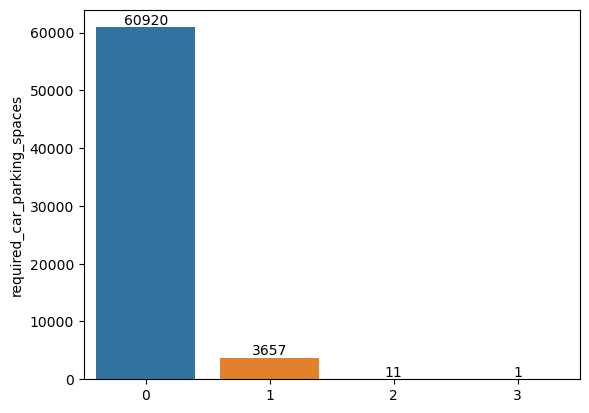

In [34]:
drow_barplot_values(hotel_train['required_car_parking_spaces'])

Более одного парковочного места на один номер это скорее всего ошибки. Среднее близко к нулю, медиана нулевая. Заменим эти значения на медиану.

In [35]:
hotel_train.loc[hotel_train['required_car_parking_spaces'] > 1,
                'required_car_parking_spaces'] = hotel_train[
                    'required_car_parking_spaces'].median()
hotel_test.loc[hotel_test['required_car_parking_spaces'] > 1,
               'required_car_parking_spaces'] = hotel_test[
                   'required_car_parking_spaces'].median()

И в заключении предобработки необходимо проверить невозможные бронирования:

Это бронирование без взрослых.

Если такие есть - эти строки будут удалены.

In [36]:
print('Тренировочная выборка:')
print('Количество бронирований без взрослых:',
      len(hotel_train.loc[hotel_train['adults'] == 0]))
print('Тестовая выборка:')
print('Количество бронирований без взрослых:',
      len(hotel_test.loc[hotel_test['adults'] == 0]))

Тренировочная выборка:
Количество бронирований без взрослых: 166
Тестовая выборка:
Количество бронирований без взрослых: 68


Удаляем эти строки.

In [37]:
hotel_train = hotel_train.loc[hotel_train['adults'] != 0]
hotel_test = hotel_test.loc[hotel_test['adults'] != 0]

### Корреляция целевого и остальных признаков

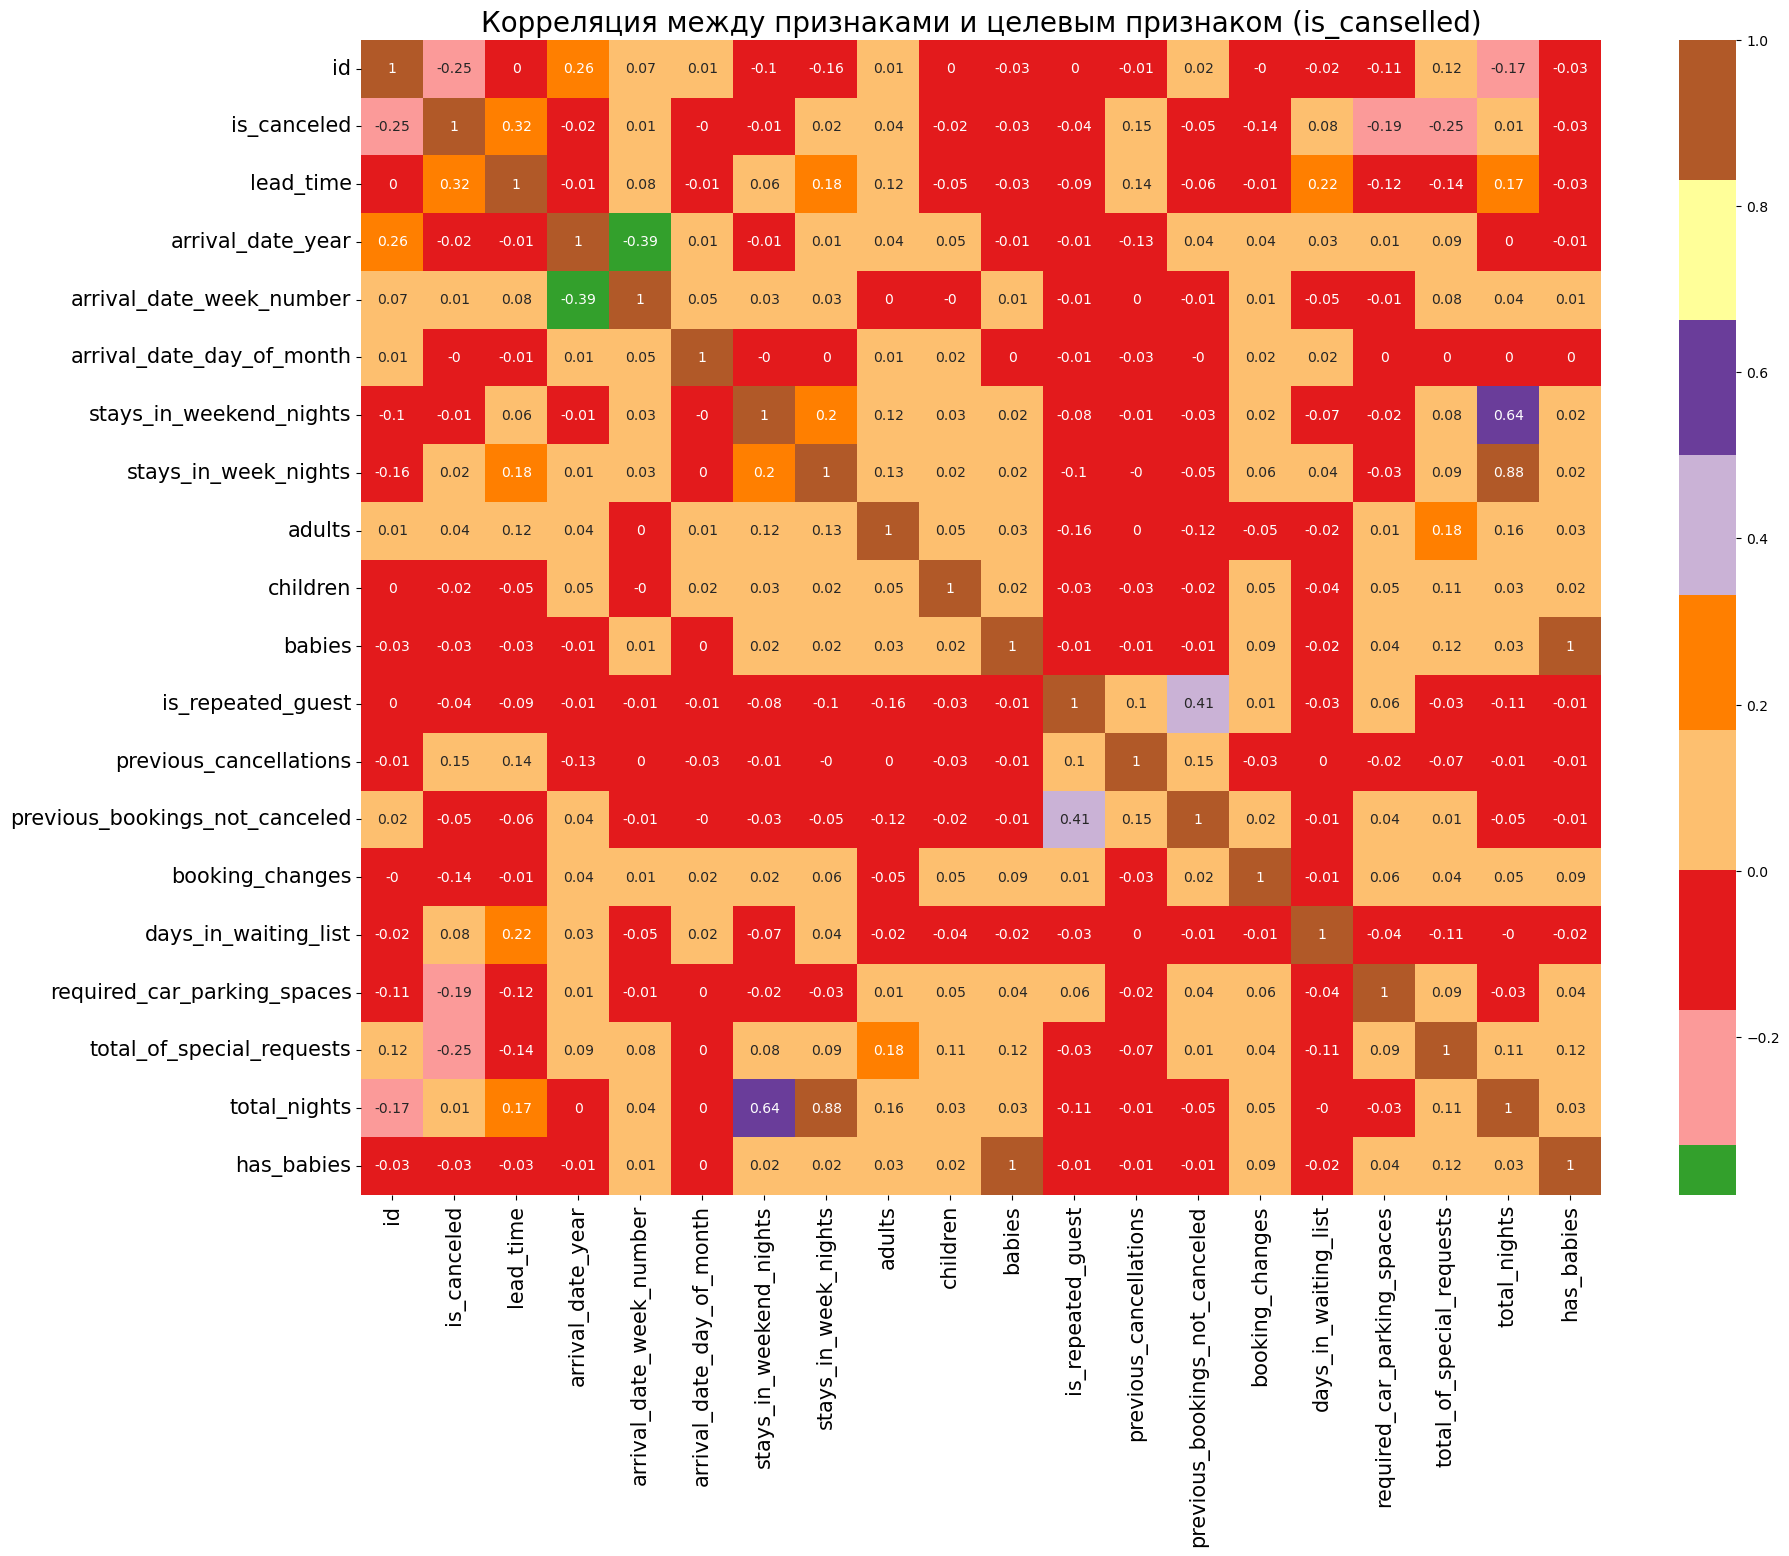

In [38]:
corr_matrix = hotel_train.drop([
    'arrival_date_month', 'meal', 'country', 'distribution_channel',
    'customer_type', 'reserved_room_type'
],
                               axis=1).corr().round(2)
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, cmap='Paired', center=0, annot=True)
plt.title('Корреляция между признаками и целевым признаком (is_canselled)',
          fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

На диаграмме видна высокая корреляция между столбцами `stays_in_weekend_nights`, `stays_in_week_nights`, `total_nights`. Ниже видно что `total_nights` это `stays_in_weekend_nights`+ `stays_in_week_nights`. Соответсвенно эти два столбца можно будет удалить

In [39]:
print((hotel_train['total_nights'] == \
       hotel_train['stays_in_weekend_nights'] + hotel_train['stays_in_week_nights']).value_counts())

True    64423
dtype: int64


По всему датасету есть соответсвие, что `total_nights` это `stays_in_weekend_nights`+ `stays_in_week_nights`. 

In [40]:
hotel_train[[
    'stays_in_weekend_nights', 'stays_in_week_nights', 'total_nights'
]].head()

,stays_in_weekend_nights,stays_in_week_nights,total_nights
0,0,1,1
1,0,2,2
2,0,2,2
3,0,2,2
4,0,3,3


Удаляем сразу не нужные столбцы

In [41]:
hotel_train = hotel_train.drop(
    ['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1)
hotel_test = hotel_test.drop(
    ['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1)

У остальных признаков корреляция слабая

### Визуализация процента отмененных бронирований

**Столбец `meal` — опции заказа:**
- `SC` — нет дополнительных опций;
- `BB` — включён завтрак;
- `HB` — включён завтрак и обед;
- `FB` — включён завтрак, обед и ужин. 

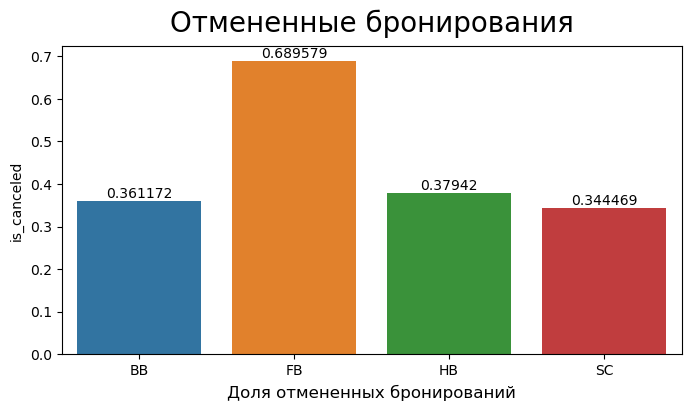

In [42]:
drow_barplot_percent(hotel_train, 'meal', 'is_canceled', (8, 4))

**Максимальное количество отмен у номеров с трехразовым пританием**

**Столбец `adults` — количество взрослых:**

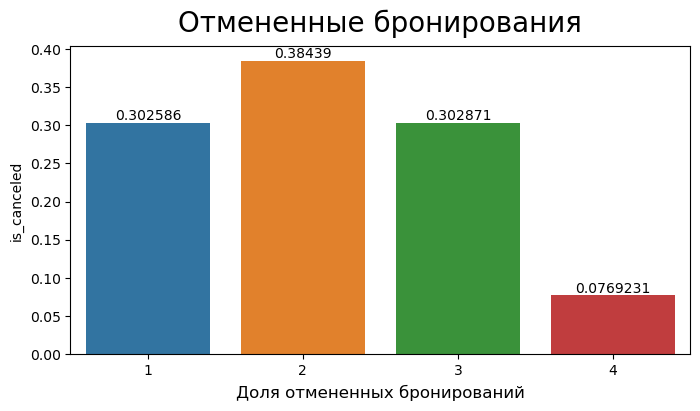

In [43]:
drow_barplot_percent(hotel_train, 'adults', 'is_canceled', (8, 4))

**Максимальное количество при заселении 2-х взрослых**

**Столбец `children` — количество детей от 3-х до 14 лет:**

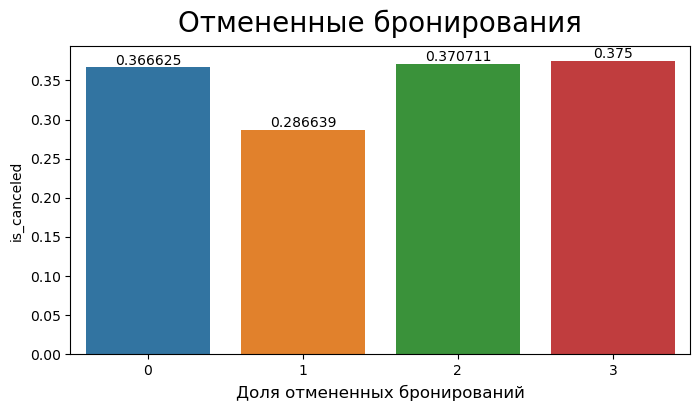

In [44]:
drow_barplot_percent(hotel_train, 'children', 'is_canceled', (8, 4))

**Почти одинаковое количетсво отмен при заселении без детей, а текже с 2-мя и 3-мя детьми**

**Столбец `babies` — количетсво младенцев:**

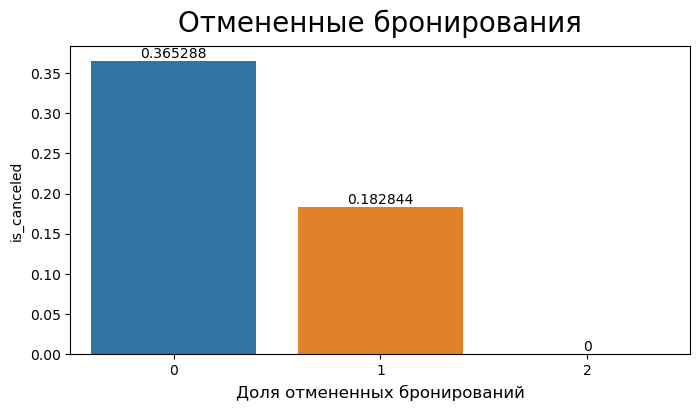

In [45]:
drow_barplot_percent(hotel_train, 'babies', 'is_canceled', (8, 4))

**С младенцеми всего 20% отменненых бронирований**

**Столбец `previous_cancellations` — количество отменённых заказов у клиента:**

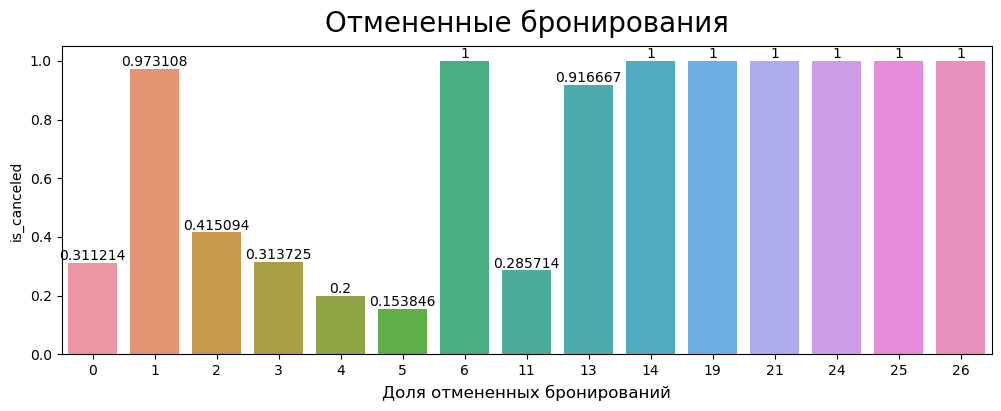

In [46]:
drow_barplot_percent(hotel_train, 'previous_cancellations', 'is_canceled', (12, 4))

**Начинает вырисовываться портрет недобросоветсного клиент: больше 11 ранее отмененных броней - гарантируют отмену брони в дальнейшем**

**Столбец `reserved_room_type` — тип забронированной комнаты:**

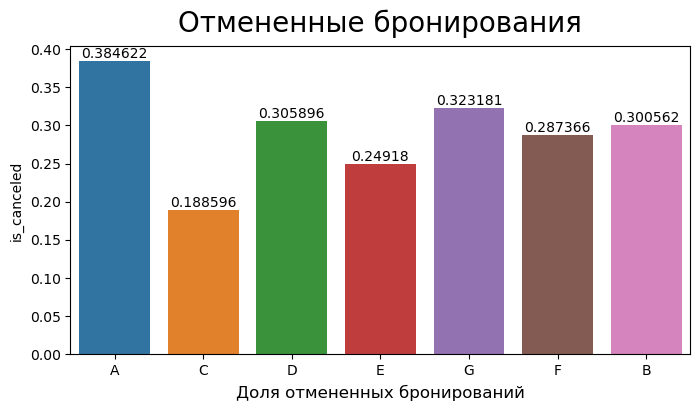

In [47]:
drow_barplot_percent(hotel_train, 'reserved_room_type', 'is_canceled', (8, 4))

**Большего всего отмен у номеров типа А, меньше всего у типа B**

**Столбец `booking_changes` — количество изменений параметров заказа:**

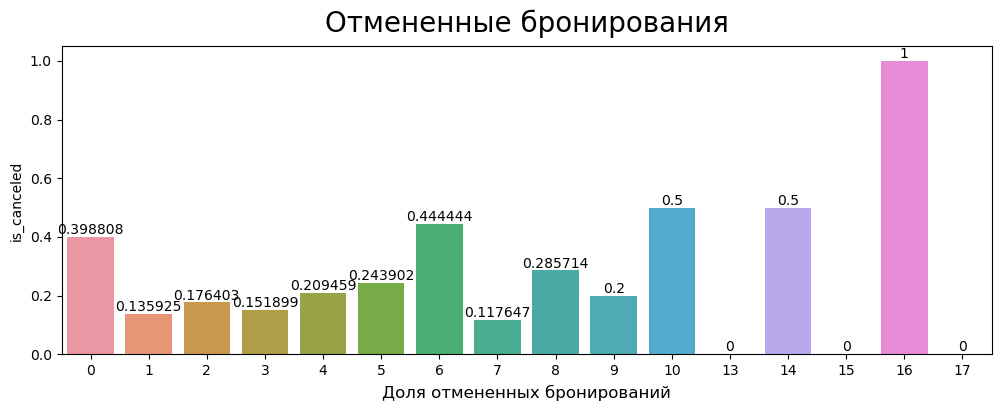

In [48]:
drow_barplot_percent(hotel_train, 'booking_changes', 'is_canceled', (12, 4))

**Столбец `customer_type` — тип заказчика:**

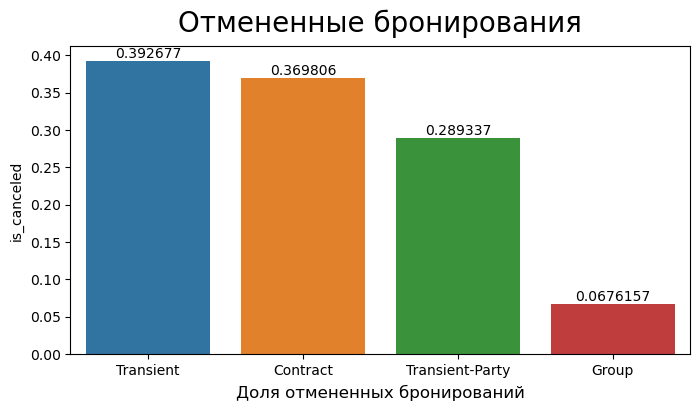

In [49]:
drow_barplot_percent(hotel_train, 'customer_type', 'is_canceled', (8, 4))

**Столбец `required_car_parking_spaces` — тип заказчика:**  

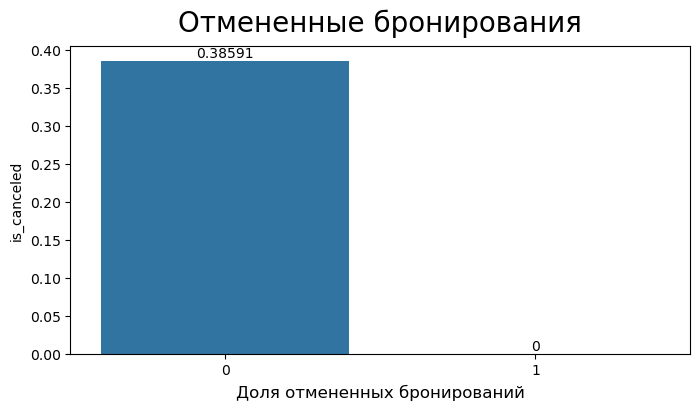

In [50]:
drow_barplot_percent(hotel_train, 'required_car_parking_spaces', 'is_canceled', (8, 4))

**Отмены только у номеров без парковок**

**Столбец `total_of_special_requests` — количество специальных отметок:**

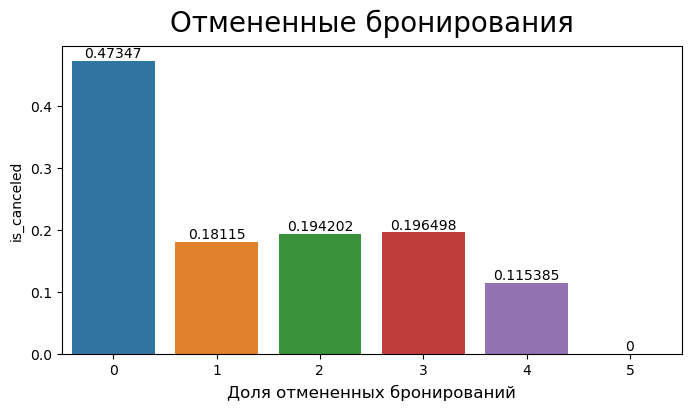

In [51]:
drow_barplot_percent(hotel_train, 'total_of_special_requests', 'is_canceled', (8, 4))

**Столбец `total_night` — общее количество ночей:**  

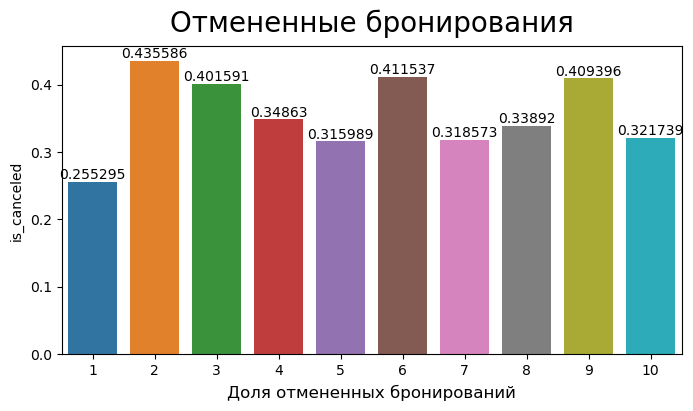

In [52]:
drow_barplot_percent(hotel_train, 'total_nights', 'is_canceled', (8, 4))

**Меньше всего отмен у номеров на 1 ночь.** 

### Проверка на дисбаланс целевого признака

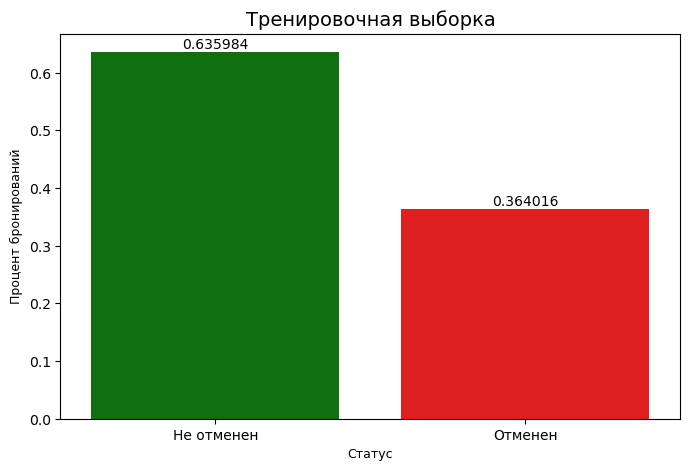

In [53]:
plt.figure(figsize=(8, 5))
plt.title("Тренировочная выборка", fontsize=14)
ax = sns.barplot(x=hotel_train['is_canceled'].unique(),
                 y=hotel_train['is_canceled'].value_counts(normalize=True),
                 palette=['green', 'red'])
plt.xlabel("Статус", fontsize=9)
plt.ylabel("Процент бронирований", fontsize=9)
plt.xticks(ticks=[0, 1], labels=['Не отменен', 'Отменен'])
# для параметра bar_label необходим matplotlib версии не ниже 3.4
# в тренажере практикума к сожалению версия ниже.
# значения столбцов не выводятся...
plt.bar_label(ax.containers[0])
plt.show()

Виден дисбаланс в целевом признаке, примерно 63,5% на 36,5%

**Вывод**

В результате предобработки и исследовательского анализа было выполнено:

- изменены типы данных на оптимальные и оптимизирована память;
- выявлены и исправлены неявные дубликаты в виде дублированных значений, появившиеся из-за пробелов в написании значений;
- выбросы в данных заменены на медианные значения или удалены;
- в результате анализа выбросов, были выявлены полные дубликаты строк с разным столбцом `id`, столбец в дальнейшем не потребуется, он удален, дубликаты удалены;
- выявлена сильная корреляция между столбцами `stays_in_weekend_nights`, `stays_in_week_nights`, `total_nights`, столбец `total_nights` это `stays_in_weekend_nights`+ `stays_in_week_nights`, соответсвенно эти два столбца удалены;
- в целевом признаке `is_canceled` дисбаланс примерно 63,5% на 36,5%.

## Формулировка ML-задачи на основе бизнес-задачи

Прибыль отеля - это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

Если клиент заселился в расчете прибыли нужно учитывать следующие параметры:
 - стоимость номера за ночь в зависимости от категории номера `night_price`, 
 - количество ночей `total_nights`,
 - стоимость разового обслуживания в зависимости от категории номера `service_price`,
 - количество обслуживаний номера в течение проживания заказчика, обслуживание должно проводиться каждые два дня. Но тут есть один ньюанс. Если клиент живет в отеле две ночи, то получается что следующая уборка должна быть во время его выезда. Соответсвенно это будет уже уборка для других постояльцев перед заселением (даже если будет простой номера). Соответсвенно два раза платить за уборку не нужно. Это лишгие затраты. 
 
Отсюда прибыль за номер можно считать по формулам:
- 1 ночь: `income` = `seasonal_price` * `total_nights` - `service_price`
- от 2-х ночей: `income` = `seasonal_price` * `total_nights` - `service_price` * (1 + `total_nights` // 2)

Если клиент отказался, то `income` = - `service_price`

In [54]:
# Словарь с тарифами за ночь по категориям номеров
price_per_night = {
    'A': 1000,
    'B': 800,
    'C': 600,
    'D': 550,
    'E': 500,
    'F': 450,
    'G': 350
}

# Словарь с тарифами за разовое обслуживание по категориям номеров
service_price = {
    'A': 400,
    'B': 350,
    'C': 350,
    'D': 150,
    'E': 150,
    'F': 150,
    'G': 150
}

# Словарь с сезонными коэффициентами
coeff = {
    'July': 1.4,
    'August': 1.4,
    'September': 1.2,
    'October': 1.2,
    'November': 1.2,
    'December': 1,
    'January': 1,
    'February': 1,
    'March': 1.2,
    'April': 1.2,
    'May': 1.2,
    'June': 1.4
}

### Функция для подсчета прибыли отеля

In [55]:
def add_column(data):
    # создание столбца с тарифом за одну ночь в зависимости от категории номера
    data['night_price'] = data['reserved_room_type'].map(price_per_night)
    # создание столбца с сезонными коэффициентами
    data['season_coeff'] = data['arrival_date_month'].map(coeff)
    # создание столбца с тарифом за одну ночь в зависимости от категории номера и сезонного коэффициента
    data['seasonal_price'] = data['night_price'] * data['season_coeff']
    # создание столбца с тарифом сервисного обслуживания в зависимости от категории номера
    data['service_price'] = data['reserved_room_type'].map(service_price)

In [56]:
def count_revenue(data, predictions=False):
    '''
    Универсальная функция вычисляет доход в зависимости от переданных параметров:
    1. При передаче параметров по умолчанию predictions=False
       прибыль вычисляется по исходному столбцу 'is_canceled'.  
    2. При передаче параметров predictions=True:
       
       is_canceled = 0, predictions = 0 — постоялец заселился (profit > 0), 
       модель предсказала, что он заселится. В этом случае прибыль отеля никак не меняется.

       is_canceled = 0, predictions = 1 — постоялец заселился (profit > 0), 
       модель предсказала, что он отменит. В этом случае постоялец внесёт депозит, 
       который пойдёт в счёт оплаты, то есть в этом случае прибыль отеля тоже никак не меняется.

       is_canceled = 1, predictions = 0 — постоялец отменил бронь (profit < 0), 
       модель предсказала, что он заселится, то есть депозит с такого клиента не брали. 
       Тогда прибыль отеля тоже никак не меняется, отель просто потерял деньги, 
       как и до внедрения модели.

       is_canceled = 1, predictions = 1 — постоялец отменил бронь (profit < 0), 
       модель предсказала, что он отменит, с постояльца взяли депозит в 80% от стоимости номера 
       за одни сутки с учетом сезонного коэффициента и затрат на разовую уборку, 
       отель потеряет только 20% от той суммы, которую терял без модели, 
       так как остальное покроет депозит
      
    '''

    profit_one_night = data['seasonal_price'] * \
        data['total_nights'] - data['service_price']
    profit_more_one_night = data['seasonal_price'] * data['total_nights'] - \
        data['service_price'] * (1 + data['total_nights'] // 2)
    loss = -data['seasonal_price'] - data['service_price']
    deposit = (data['seasonal_price'] + data['service_price']) * 0.8
    loss_with_deposit = loss + deposit

    # проверка условия на наличие предсказанных значений

    if not predictions:  # без предсказанных значений
        if (data['is_canceled'] == 0) and (data['total_nights'] < 2):
            # подсчет прибыли при заселении до 2-х ночей включительно
            revenue = profit_one_night
        elif (data['is_canceled'] == 0) and (data['total_nights'] >= 2):
            # подсчет прибыли при заселении от 3-х ночей
            revenue = profit_more_one_night
        else:
            # убыток при отмене брони
            revenue = loss

    # предсказанных значения есть
    elif predictions:
        if (data['is_canceled'] == 0) and (data['predictions'] == 0):
            if data['total_nights'] < 2:
                # подсчет прибыли при заселении до 2-х ночей включительно
                revenue = profit_one_night
            else:
                # подсчет прибыли при заселении от 3-х ночей
                revenue = profit_more_one_night
        elif (data['is_canceled'] == 0) and (data['predictions'] == 1):
            if data['total_nights'] < 2:
                # подсчет прибыли при заселении до 2-х ночей включительно
                revenue = profit_one_night - deposit
            else:
                # подсчет прибыли при заселении от 3-х ночей
                revenue = profit_more_one_night - deposit

        elif (data['is_canceled'] == 1) and (data['predictions'] == 0):
            # убыток при отмене брони
            revenue = loss
        else:
            revenue = loss_with_deposit

    return revenue

Добавляем столбец с прибылью в тренировочную выборку

In [57]:
add_column(hotel_train)
hotel_train['profit'] = hotel_train.apply(count_revenue, axis=1)
display(hotel_train.groupby('arrival_date_year')['profit'].sum().reset_index())

,arrival_date_year,profit
0,2015,17956050.0
1,2016,48464560.0


Суммарная прибыль за все годы:

In [58]:
print('Суммарная прибыль за все годы:', hotel_train['profit'].sum(), 'у.е.')

Суммарная прибыль за все годы: 66420610.0 у.е.


**Вывод**

Бизнес метрика для отеля это прибыль. Соответсвенно необходимо разработать модель ML которая позволит увеличить прибыль за счет предсказаний неблагонадёжности клиента.

## Разработка модели ML

Целевым признаком у нас является столбец `is_canceled`, имеющий значение 0 или 1. 

Для исследования будем обучать модели:

- Решающее дерево,
- Случайный лес,
- Логистическая регрессия.

Для обучения данные нужно подготовить.

### Признаки для обучения модели 

Признаками для обучения оставим следующие столбцы : `lead_time`, `arrival_date_year`, `arrival_date_month`,
 `arrival_date_day_of_month`, `adults`, `children`, `babies`, `meal`, `country`, `distribution_channel`, `is_repeated_guest`, `previous_cancellations`, `previous_bookings_not_canceled`, `reserved_room_type`, `booking_changes`, `days_in_waiting_list`, `customer_type`, `required_car_parking_spaces`, `total_of_special_requests`, `total_nights`.
       
`arrival_date_week_number` - можно удалить, т.к уже есть день, месяц, а так же удалим добавленные столбцы в тренировочной выборке при расчете прибыли.

`arrival_date_year` - не понадобится, так как в выборке прошедшие года, а модель предсказывает отмену в текущем

Целевой признак - `is_canceled`.

In [59]:
hotel_train = hotel_train.drop([
    'arrival_date_week_number', 'arrival_date_year', 'night_price',
    'season_coeff', 'seasonal_price', 'service_price', 'profit'
],
                               axis=1)
hotel_test = hotel_test.drop(['arrival_date_week_number', 'arrival_date_year'],
                             axis=1)

### Формирование датасетов для признаков и целевого признака.

In [60]:
target_train = hotel_train['is_canceled']
features_train = hotel_train.drop(['id', 'is_canceled', 'babies'], axis=1)
target_test = hotel_test['is_canceled']
features_test = hotel_test.drop(['id', 'is_canceled', 'babies'], axis=1)

In [61]:
print(f"Размер выборок после разбиения.\n")
print(
    f"Обучающая выборка: признаки - {features_train.shape}, целевой признак - {target_train.shape}\n"
)
print(
    f"Тестовая выборка: признаки - {features_test.shape}, целевой признак - {target_test.shape}"
)

Размер выборок после разбиения.

Обучающая выборка: признаки - (64423, 19), целевой признак - (64423,)

Тестовая выборка: признаки - (32138, 19), целевой признак - (32138,)


### Избавляемся от категориальных признаков. 

Применяем метод `OrdinalEncoder`.

In [62]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(features_train)
features_train = encoder.transform(features_train)
features_test = encoder.transform(features_test)

### Масштабирование признаков

In [63]:
scaler = RobustScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### Метрика для модели

В качестве метрики оценки качества будем использовать F1-меру. F1-мера - это агрегирующая метрика, среднее гармоническое полноты и точности. 

По метрикам прибыли получется так:
    
1. `is_canceled = 0, predictions = 0` — постоялец заселился (profit > 0), модель предсказала, что он заселится. В этом случае прибыль отеля никак не меняется - это `TN`

2. `is_canceled = 0, predictions = 1` — постоялец заселился (profit > 0), модель предсказала, что он отменит. В этом случае постоялец внесёт депозит, который пойдёт в счёт оплаты, то есть в этом случае прибыль отеля тоже никак не меняется- это `FP`

3. `is_canceled = 1, predictions = 0` — постоялец отменил бронь (profit < 0), модель предсказала, что он заселится, то есть депозит с такого клиента не брали. Тогда прибыль отеля тоже никак не меняется, отель просто потерял деньги, как и до внедрения модели - это `FN`.

4. `is_canceled = 1, predictions = 1` — постоялец отменил бронь (profit < 0), модель предсказала, что он отменит, с постояльца взяли депозит в 80% от стоимости номера за одни сутки с учетом сезонного коэффициента и затрат на разовую уборку, отель потеряет только 20% от той суммы, которую терял без модели, так как остальное покроет депозит - это `TP`
    
Отель теряет деньги при `FN` и `TP`, а это `Recall`.
    
Но модель также может ошибиться  в ложноположительную сторону `FP`, а это `Precision`. 

Полнота и точность оценивают качество прогноза положительного класса с разных позиций. `Recall` описывает, как хорошо модель разобралась в особенностях этого класса и распознала его. `Precision` выявляет, не переусердствует ли модель, присваивая положительные метки.
    
Поэтому я и выбрал агрегирующую метрику  — `F1-меру`. Это среднее гармоническое полноты и точности.

### Обучение моделей 

- Решающее дерево,
- Случайный лес,
- Логистическая регрессия.

#### С дисбалансом данных 

**Решающее дерево**

In [64]:
best_model_tree = None
best_f1_tree = 0
best_depth_tree = 0
best_depth_leaf = 0

for depth in range(1, 16):
    for leaf in range(1, 11):
        model_tree = DecisionTreeClassifier(random_state=RANDOM,
                                            max_depth=depth,
                                            min_samples_leaf=leaf)
        scores_f1 = cross_val_score(model_tree,
                                    features_train,
                                    target_train,
                                    cv=5,
                                    scoring='f1')
        best_f1 = round(scores_f1.mean(), 3)
        if best_f1_tree < best_f1:
            best_model_tree = model_tree
            best_f1_tree = best_f1
            best_depth_tree = depth
            best_depth_leaf = leaf

print(
    f'''Наилучшая F1 - мера {best_f1_tree} в модели решающего леса достигается при глубине {best_depth_tree} и количестве листьев {best_depth_leaf}'''
)

Наилучшая F1 - мера 0.625 в модели решающего леса достигается при глубине 3 и количестве листьев 1


**Случайный лес**

In [65]:
best_model_forest = None
best_f1_forest = 0
best_depth_forest = 0
best_estim_forest = 0

for depth in range(1, 16):
    for n_estim in range(1, 11):
        model_forest = RandomForestClassifier(random_state=RANDOM,
                                              max_depth=depth,
                                              n_estimators=n_estim)
        scores_f1 = cross_val_score(model_forest,
                                    features_train,
                                    target_train,
                                    cv=5,
                                    scoring='f1')
        best_f1 = round(scores_f1.mean(), 3)
        if best_f1_forest < best_f1:
            best_model_forest = model_forest
            best_f1_forest = best_f1
            best_depth_forest = depth
            best_estim_forest = n_estim

print(
    f'''Наилучшая F1 мера - {best_f1_forest} в модели случайного леса достигается при глубине {best_depth_forest} и количестве деревьев {best_estim_forest}'''
)

Наилучшая F1 мера - 0.631 в модели случайного леса достигается при глубине 4 и количестве деревьев 7


**Логистическая регрессия**

In [66]:
solver_params = ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
penalty_params = ['l2']
best_model_log = None
best_f1_log = 0
best_solver_regression = ''
best_penalty_regression = ''

for sol in solver_params:
    for pen in penalty_params:
        model_log = LogisticRegression(random_state=RANDOM,
                                       solver=sol,
                                       penalty=pen)
        scores_f1_log = cross_val_score(model_log,
                                        features_train,
                                        target_train,
                                        cv=5,
                                        scoring='f1')
        best_f1 = round(scores_f1_log.mean(), 3)
        if best_f1_log < best_f1:
            best_model_log = model_log
            best_f1_log = best_f1
            best_solver_regression = sol
            best_penalty_regression = pen

print(
    f'''Наилучшая F1 - мера {best_f1_log} в модели логисической регрессии достигается при параметрах Solver: {best_solver_regression} и Penalty: {best_penalty_regression}'''
)

Наилучшая F1 - мера 0.602 в модели логисической регрессии достигается при параметрах Solver: lbfgs и Penalty: l2


#### Балансировка целевого признака 

Для балансировки целевого признака можно использовать гиперпараметр `class_weight='balanced'`

**Решающее дерево**

In [67]:
best_model_tree_balance = None
best_f1_tree_balance = 0
best_depth_tree_balance = 0
best_leaf_tree_balance = 0

for depth in range(1, 16):
    for leaf in range(1, 11):
        model_tree_balance = DecisionTreeClassifier(random_state=RANDOM,
                                                    max_depth=depth,
                                                    min_samples_leaf=leaf,
                                                    class_weight='balanced')
        scores_f1 = cross_val_score(model_tree_balance,
                                    features_train,
                                    target_train,
                                    cv=5,
                                    scoring='f1')
        best_f1 = round(scores_f1.mean(), 3)
        if best_f1_tree_balance < best_f1:
            best_model_tree_balance = model_tree_balance
            best_f1_tree_balance = best_f1
            best_depth_tree_balance = depth
            best_depth_tree_balance = leaf

print(
    f'''Наилучшая F1 - мера {best_f1_tree_balance} в модели решающего леса достигается при глубине {best_depth_tree_balance} и количестве листьев {best_depth_leaf}'''
)

Наилучшая F1 - мера 0.649 в модели решающего леса достигается при глубине 1 и количестве листьев 1


**Случайный лес**

In [68]:
best_model_forest_balance = None
best_f1_forest_balance = 0
best_depth_forest_balance = 0
best_estim_forest_balance = 0

for depth in range(1, 16):
    for n_estim in range(1, 11):
        model_forest_balance = RandomForestClassifier(random_state=RANDOM,
                                                      max_depth=depth,
                                                      n_estimators=n_estim,
                                                      class_weight='balanced')
        scores_f1 = cross_val_score(model_forest_balance,
                                    features_train,
                                    target_train,
                                    cv=5,
                                    scoring='f1')
        best_f1 = round(scores_f1.mean(), 3)
        if best_f1_forest_balance < best_f1:
            best_model_forest_balance = model_tree_balance
            best_f1_forest_balance = best_f1
            best_depth_forest_balance = depth
            best_estim_forest_balance = n_estim

print(
    f'''Наилучшая F1 мера - {best_f1_forest_balance} в модели случайного леса достигается при глубине {best_depth_forest_balance} и количестве деревьев {best_estim_forest_balance}'''
)

Наилучшая F1 мера - 0.657 в модели случайного леса достигается при глубине 7 и количестве деревьев 9


**Логистическая регрессия**

In [69]:
best_model_log_balance = None
best_f1_log_balance = 0
best_solver_regression_balance = ''
best_penalty_regression_balance = ''

for sol in solver_params:
    for pen in penalty_params:
        model_log_balance = LogisticRegression(random_state=RANDOM,
                                               solver=sol,
                                               penalty=pen,
                                               class_weight='balanced')
        scores_f1_log = cross_val_score(model_log_balance,
                                        features_train,
                                        target_train,
                                        cv=5,
                                        scoring='f1')
        best_f1 = round(scores_f1_log.mean(), 3)
        if best_f1_log_balance < best_f1:
            best_model_log_balance = model_log
            best_f1_log_balance = best_f1
            best_solver_regression_balance = sol
            best_penalty_regression_balance = pen

print(
    f'''Наилучшая F1 - мера {best_f1_log_balance} в модели логисической регрессии достигается при параметрах Solver: {best_solver_regression_balance} и Penalty: {best_penalty_regression_balance}'''
)

Наилучшая F1 - мера 0.627 в модели логисической регрессии достигается при параметрах Solver: newton-cg и Penalty: l2


### Результаты полученных значений F1-меры в виде датафрейма

In [70]:
data_f1 = {
    'С дисбалансом классов': [best_f1_tree, best_f1_forest, best_f1_log],
    'Балансировка классов':
    [best_f1_tree_balance, best_f1_forest_balance, best_f1_log_balance],
}

data_result = pd.DataFrame(
    data_f1,
    index=['Дерево решений', 'Случайный лес', 'Логистическая регрессия'])
data_result

,С дисбалансом классов,Балансировка классов
Дерево решений,0.625,0.649
Случайный лес,0.631,0.657
Логистическая регрессия,0.602,0.627


**Наилучшая модель - это случайный лес со значением F1 меры - 0.657 при глубине 7 и количестве деревьев 9 и балансировке классов с использованием гиперпараметра `class_weight='balanced'`**

### Проверка модели на тестовой выборке

In [71]:
model_forest_tree = RandomForestClassifier(random_state=RANDOM,
                                           max_depth=7,
                                           n_estimators=9,
                                           class_weight='balanced')
scores_f1 = cross_val_score(model_forest_tree,
                            features_test,
                            target_test,
                            cv=5,
                            scoring='f1')
best_test = round(scores_f1.mean(), 3)

model_forest_tree.fit(features_train, target_train)
predicted_test = model_forest_tree.predict(
    features_test)  # запись предсказанных значений

In [72]:
print('Значение F1-меры:', best_test)

Значение F1-меры: 0.647


Значение F-1 меры на тестовой выборке получилось похуже

### ROC-кривая и значение AUC-ROC лучшей модели

'Значение метрики AUC-ROC:'

0.821

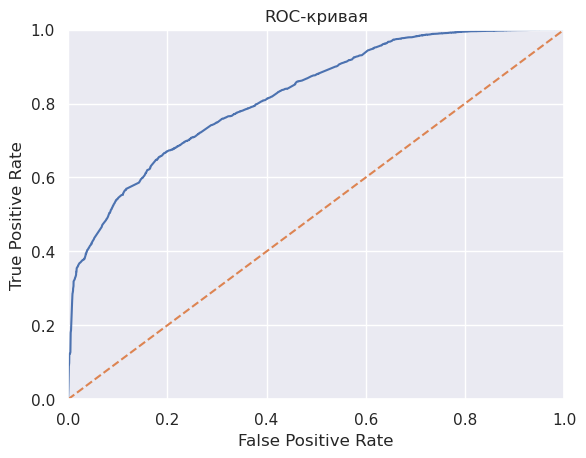

In [73]:
probabilities_test = model_forest_tree.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = round(roc_auc_score(target_test, probabilities_one_test), 3)

display('Значение метрики AUC-ROC:', auc_roc)

sns.set(font_scale=1)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Матрица ошибок для лучшей выбранной модели

In [74]:
conf_matrix = confusion_matrix(target_test, predicted_test)

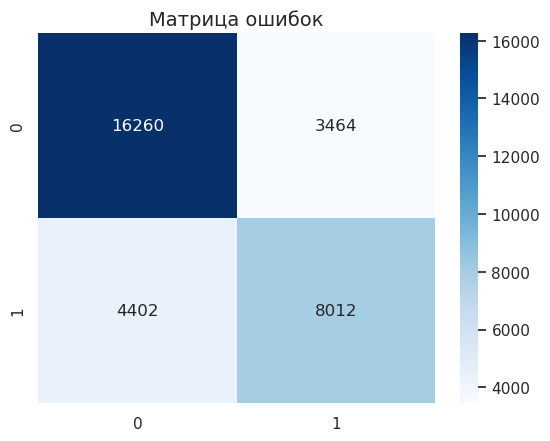

In [75]:
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title("Матрица ошибок", size=14)

plt.show()

Что в итоге:

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:
   
   - *TN* в левом верхнем углу. 16260 правильных ответов. Статус отмены брони соответсвует прогнозу.
   - *TP* в правом нижнем углу. 8012 правильных ответов. Статус подтверждения брони соответсвует прогнозу.

2. Вне главной диагонали — ошибочные варианты:

   - *FP* в правом верхнем углу. 3464 ошибок ошибочных предсказаний первого рода. Был статус отмены брони, а модель предсказала подверждение 
   - *FN* в левом нижнем углу. 4402 ошибочных предсказаний второго рода. Был статус подтверждения брони, а модель предсказала отмену.

In [76]:
TP = conf_matrix[0][0]
TN = conf_matrix[1][1]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

total = TN + TP + FP + FN

print('Всего предсказаний:', total)
print(f'Правильно предсказанные ответы: {round((TP+TN)*100/total, 2)}%')
print(f'Ошибки в прогнозах: {round((FP+FN)*100/total, 2)}%')

Всего предсказаний: 32138
Правильно предсказанные ответы: 75.52%
Ошибки в прогнозах: 24.48%


**75,52% правильных прогнозов достаточно высокий показатель**

<div class="alert alert-success">
<h2>Комментарий ревьюера<a class="tocSkip"></a></h2>
    
**Отлично!** ✔️: 👍</div>

#### Матрица ошибок для остальных моделей.

**Решающее дерево**

In [77]:
model_tree = DecisionTreeClassifier(random_state=RANDOM,
                                    max_depth=1,
                                    min_samples_leaf=1,
                                    class_weight='balanced')
model_tree.fit(features_train, target_train)
predicted_test_tree = model_tree.predict(
    features_test)  # запись предсказанных значений

In [78]:
conf_matrix = confusion_matrix(target_test, predicted_test_tree)

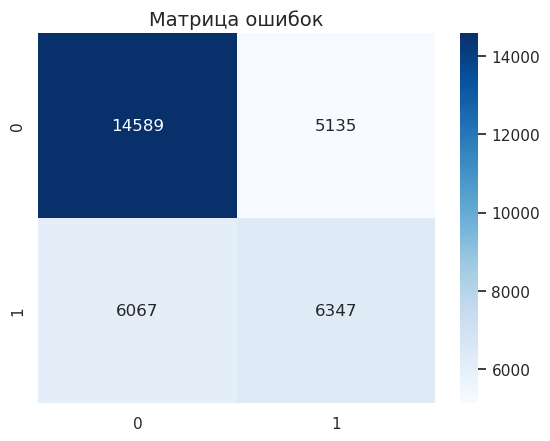

In [79]:
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title("Матрица ошибок", size=14)

plt.show()

In [80]:
TP = conf_matrix[0][0]
TN = conf_matrix[1][1]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

total = TN + TP + FP + FN

print('Всего предсказаний:', total)
print(f'Правильно предсказанные ответы: {round((TP+TN)*100/total, 2)}%')
print(f'Ошибки в прогнозах: {round((FP+FN)*100/total, 2)}%')

Всего предсказаний: 32138
Правильно предсказанные ответы: 65.14%
Ошибки в прогнозах: 34.86%


**Логистическая регрессия**

In [81]:
model_regression = LogisticRegression(random_state=RANDOM,
                                      solver='lbfgs',
                                      penalty='l2',
                                      class_weight='balanced')
model_regression.fit(features_train, target_train)
predicted_test_regression = model_regression.predict(
    features_test)  # запись предсказанных значений

In [82]:
conf_matrix = confusion_matrix(target_test, predicted_test_regression)

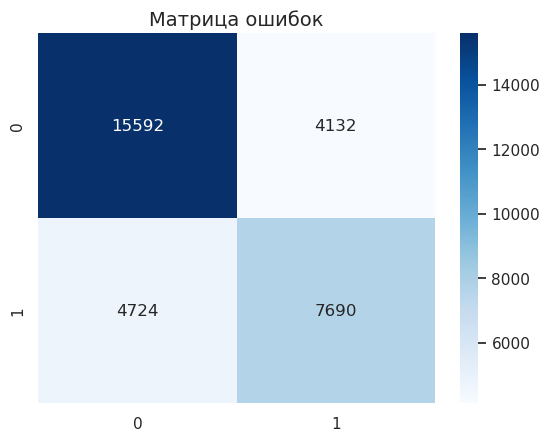

In [83]:
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title("Матрица ошибок", size=14)

plt.show()

In [84]:
TP = conf_matrix[0][0]
TN = conf_matrix[1][1]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

total = TN + TP + FP + FN

print('Всего предсказаний:', total)
print(f'Правильно предсказанные ответы: {round((TP+TN)*100/total, 2)}%')
print(f'Ошибки в прогнозах: {round((FP+FN)*100/total, 2)}%')

Всего предсказаний: 32138
Правильно предсказанные ответы: 72.44%
Ошибки в прогнозах: 27.56%


### Подсчет прибыли для тестовой выборки согласно предсказаниям и с учетом введения депозита.

Применим ранее подготовленные функции `add_column` и `count_revenue` в двух вариантах для тестовой выборки:

1. По признаку `is_canceled` без предсказаний.
2. С предсказаниями и депозитом.

In [85]:
# создание столбцов для расчета прибыли
add_column(hotel_test)

Подсчет прибыли.

Добавление столбца с прибылью в тестовую выборку по модели **Дерево решений**.

In [86]:
hotel_test['profit'] = hotel_test.apply(count_revenue, axis=1)
hotel_test['predictions'] = predicted_test_tree

In [87]:
hotel_test['profit_predict'] = hotel_test.apply(count_revenue,
                                                predictions=True,
                                                axis=1)

In [88]:
print('Суммарная прибыль за 2017 без внедрения модели:',
      hotel_test['profit'].sum(), 'у.е.')
print('Суммарная прибыль за 2017 после внедрения модели с депозитом:',
      hotel_test['profit_predict'].sum(), 'у.е.')

Суммарная прибыль за 2017 без внедрения модели: 32521250.0 у.е.
Суммарная прибыль за 2017 после внедрения модели с депозитом: 34425138.0 у.е.


In [89]:
net_profit_deposit_tree = hotel_test['profit_predict'].sum(
) - hotel_test['profit'].sum() - BUDGET
print(
    'Разница между значениями у модели с предсказаниями и депозитом с учетом бюджета 400_000 на внедрение систему и моделью без предсказаний:',
    net_profit_deposit_tree, 'у.е.')

Разница между значениями у модели с предсказаниями и депозитом с учетом бюджета 400_000 на внедрение систему и моделью без предсказаний: 1503888.0 у.е.


Добавление столбца с прибылью в тестовую выборку по модели **Логистическая регрессия**.

In [90]:
hotel_test['predictions'] = predicted_test_regression

In [91]:
hotel_test['profit_predict'] = hotel_test.apply(count_revenue,
                                                predictions=True,
                                                axis=1)

In [92]:
print('Суммарная прибыль за 2017 без внедрения модели:',
      hotel_test['profit'].sum(), 'у.е.')
print('Суммарная прибыль за 2017 после внедрения модели с депозитом:',
      hotel_test['profit_predict'].sum(), 'у.е.')

Суммарная прибыль за 2017 без внедрения модели: 32521250.0 у.е.
Суммарная прибыль за 2017 после внедрения модели с депозитом: 37005674.0 у.е.


In [93]:
net_profit_deposit_regression = hotel_test['profit_predict'].sum(
) - hotel_test['profit'].sum() - BUDGET
print(
    'Разница между значениями у модели с предсказаниями и депозитом с учетом бюджета 400_000 на внедрение систему и моделью без предсказаний:',
    net_profit_deposit_regression, 'у.е.')

Разница между значениями у модели с предсказаниями и депозитом с учетом бюджета 400_000 на внедрение систему и моделью без предсказаний: 4084424.0 у.е.


Добавление столбца с прибылью в тестовую выборку по лучшей модели согласно метрики `F1` - **Случайного леса**.

In [94]:
hotel_test['predictions'] = predicted_test

In [95]:
hotel_test['profit_predict'] = hotel_test.apply(count_revenue,
                                                predictions=True,
                                                axis=1)

In [96]:
print('Суммарная прибыль за 2017 без внедрения модели:',
      hotel_test['profit'].sum(), 'у.е.')
print('Суммарная прибыль за 2017 после внедрения модели с депозитом:',
      hotel_test['profit_predict'].sum(), 'у.е.')

Суммарная прибыль за 2017 без внедрения модели: 32521250.0 у.е.
Суммарная прибыль за 2017 после внедрения модели с депозитом: 38001434.0 у.е.


In [97]:
net_profit_deposit = hotel_test['profit_predict'].sum(
) - hotel_test['profit'].sum() - BUDGET
print(
    'Разница между значениями у модели с предсказаниями и депозитом с учетом бюджета 400_000 на внедрение систему и моделью без предсказаний:',
    net_profit_deposit, 'у.е.')

Разница между значениями у модели с предсказаниями и депозитом с учетом бюджета 400_000 на внедрение систему и моделью без предсказаний: 5080184.0 у.е.


В итоге получаем: 
    
Прибль с учетом бюджета в 400 000 у.е. на внедрение по моделям:

1. Дерево решений - 1 503 888 у.е.
2. Случайный лес - 5 080 184 у.е.
3. Логистическая регрессия - 4 084 424 у.е.
    
Лучшая модель - Случайный лес.

**Вывод**

Были обучены три модели ML с дисбалансом и с балансировкой классов по гиперпарамеру `class_weight='balanced'`: 
- Решающее дерево,
- Случайный лес,
- Логистическая регрессия.

Лучший результат показала модель случайного леса с гиперпараметром `class_weight='balanced'`.

Значение `F1-меры` - 0.657 при глубине 7 и количестве деревьев 9

Значение метрики `AUC-ROC`: 0.821

Построена и визуализирована матрица ошибок. Модель сделала 32138 предсказаний. Из них 75,57% правильных прогнозов.

За счет правильной работы модели удалось добиться прибыли 5 080 184 у.е 

## Описание портрета «ненадёжного» клиента

Для составления портрета «ненадёжного» клиента выявим максимальные значения по количественным и категориальным признакам у модели с предсказанным значение целевого признака `'predictions' = 1` и изначального признака `'is_canceled' = 1`

### Количественные признаки

In [98]:
data = hotel_test.drop([
    'id', 'night_price', 'has_babies', 'season_coeff', 'seasonal_price',
    'service_price', 'profit', 'profit_predict'
],
                       axis=1)

In [99]:
data.query('is_canceled==1 and predictions==1').describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,8012.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
lead_time,8012.0,126.895906,76.858945,5.0,61.0,119.0,175.0,349.0
arrival_date_day_of_month,8012.0,15.779206,8.702093,1.0,8.0,15.5,23.0,31.0
adults,8012.0,1.890290,0.454188,1.0,2.0,2.0,2.0,4.0
children,8012.0,0.071018,0.324313,0.0,0.0,0.0,0.0,3.0
babies,8012.0,0.000874,0.029547,0.0,0.0,0.0,0.0,1.0
is_repeated_guest,8012.0,0.000250,0.015799,0.0,0.0,0.0,0.0,1.0
previous_cancellations,8012.0,0.000624,0.037050,0.0,0.0,0.0,0.0,3.0
previous_bookings_not_canceled,8012.0,0.000374,0.024980,0.0,0.0,0.0,0.0,2.0
booking_changes,8012.0,0.007114,0.120641,0.0,0.0,0.0,0.0,5.0


### Категориальные признаки

In [100]:
display(data.query('is_canceled==1 and predictions==1')['meal'].value_counts(normalize=True))

BB    0.818772
SC    0.126685
HB    0.053045
FB    0.001498
Name: meal, dtype: float64

In [101]:
display(data.query('is_canceled==1 and predictions==1')['country'].value_counts(normalize=True))

PRT    0.633425
GBR    0.051048
FRA    0.043310
DEU    0.036071
ITA    0.031702
         ...   
LBN    0.000125
SYC    0.000125
PAK    0.000125
UZB    0.000125
ZWE    0.000125
Name: country, Length: 81, dtype: float64

In [102]:
display(data.query('is_canceled==1 and predictions==1')['distribution_channel'].value_counts(normalize=True))

TA/TO        0.937469
Corporate    0.032951
Direct       0.029456
GDS          0.000125
Name: distribution_channel, dtype: float64

In [103]:
display(data.query('is_canceled==1 and predictions==1')['reserved_room_type'].value_counts(normalize=True))

A    0.797554
D    0.144034
E    0.032951
F    0.010734
G    0.007614
C    0.005991
B    0.001123
Name: reserved_room_type, dtype: float64

In [104]:
display(data.query('is_canceled==1 and predictions==1')['customer_type'].value_counts(normalize=True))

Transient          0.920869
Transient-Party    0.073515
Contract           0.004993
Group              0.000624
Name: customer_type, dtype: float64

**Вывод**

Ненадежный клиент может быть вывлен по следующим параметрам:

- бронирует номер заранее, в среднем - за 126 дней;
- бронирует номер в среднем на 3 ночи, но есть значения на 10 ночей - это сразу можно принять во внимание;
- в среднем это 2 взрослых, на главный маркер если будет 4 взрослых;
- имеет 3 отмены ранее и 5 изменений заказа;
- долгое подтверждение заказа - 183 дня; 
- 5 специальных отметок;
- вместе с номером выбирает включенный в стоимость завтрак;
- выбирает самый дорогой номер (A);
- выбирает только завтрак (ВВ);
- приезжает из Португалии (PRT);
- канал дистрибуции - TA/TO.

## Общий вывод

В результате исследования были проведены следующие шаги:

1. Предобработаны данные и проведен исследовательский анализ.
 
   В результате предобработки и исследовательского анализа было выполнено:

   - изменены типы данных на оптимальные и оптимизирована память;
   - выявлены и исправлены неявные дубликаты в виде дублированных значений, появившиеся из-за пробелов в написании значений;
   - выбросы в данных заменены на медианные значения или удалены;
   - выбросы в некотых признаках были оставлены, т. к. они являются маркерами «ненадёжного» клиента.
   - в целевом признаке `is_canceled` дисбаланс примерно 63,5% на 36,5%.


2. Сформулирована ML-задача на основании безнесс метрики.
  
   Бизнесс метрика - это прибыль отеля.
   
   Подсчет прибыли велся из расчет разницы между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.
   

3. Выбрана и обучена лучшая модель для предсказания и подсчитаны варианты прибыли.
     
     В качестве метрики оценки качества использовалась F1-мера и метрика AUC-ROC. F1-мера - это агрегирующая метрика,   среднее гармоническое полноты и точности. Метрика AUC-ROC показывает, как сильно наша модель отличается от случайной. AUC-ROC случайной модели - 0.5.
    
    Лучший результат показала модель решающего дерева с гиперпараметром `class_weight='balanced'`.

    Значение `F1-меры` - 0.657 при глубине 7 и количестве деревьев 9

    Значение метрики `AUC-ROC`: 0.821

    Построена и визуализирована матрица ошибок. Модель сделала 32138 предсказаний. Из них 75,57%     правильных прогнозов.

   За счет правильной работы модели удалось добиться прибыли 5 080 184 у.е 


4. Сформирован портрет «ненадёжного» клиента.

   Ненадежный клиент:

    - бронирует номер заранее, в среднем - за 126 дней,  в среднем на 3 ночи, но есть значения на 10 ночей - это сразу можно принять во внимание, в среднем это 2 взрослых, на главный маркер если будет 4 взрослых, имеет 3 отменs ранее и 5 изменений заказа, долгое подтверждение заказа - 183 дня, 5 специальных отметок,выбирает самый дорогой номер (A), выбирает только завтрак (ВВ), приезжает из Португалии (PRT), канал дистрибуции - TA/TO.
    
**Согласно исследованию рекомендуется ввести систему депозитов для клиентов предсказанием по отмени брони.**